In [1]:
import tensorflow as tf
import pandas as pd

tf.compat.v1.disable_v2_behavior()

import codecs
import numpy as np
import math
import csv
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import recall_score, precision_score # New
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
import matplotlib.pyplot as plt
import tensorflow.keras.preprocessing
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, Flatten, Add, Multiply
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Activation, BatchNormalization
# regularizers
from tensorflow.keras.layers import Conv1D, Conv2D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Dropout
from scipy import signal
import openpyxl
import seaborn as sns
from keijzer import *
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.layers import Dense, Input, Flatten, Add, concatenate, Dropout, Activation, Multiply
from tensorflow.keras.layers import LSTM, Bidirectional, GlobalMaxPooling1D, GlobalAveragePooling1D  
from tensorflow.keras.layers import Conv1D, AveragePooling1D, MaxPooling1D
from tensorflow.keras.utils import plot_model
from tensorflow.keras import activations
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
import math

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
PV = 'C:/Users/Smartgrid_ML/Documents/KMS/btm_data/korean_data/pv/seobu_pv.csv'
pv_source = pd.read_csv(PV, encoding='CP949')
pv_source = pd.DataFrame(pv_source)
pv_source = pv_source.iloc[0:1277, :]
pv_data = np.array(pv_source)

weather_17 = 'C:/Users/Smartgrid_ML/Documents/KMS/btm_data/korean_data/pv/mokpo_2017.csv'
weather_18 = 'C:/Users/Smartgrid_ML/Documents/KMS/btm_data/korean_data/pv/mokpo_2018.csv'
weather_19 = 'C:/Users/Smartgrid_ML/Documents/KMS/btm_data/korean_data/pv/mokpo_2019.csv'
weather_20 = 'C:/Users/Smartgrid_ML/Documents/KMS/btm_data/korean_data/pv/mokpo_2020.csv'

weather_17 = pd.read_csv(weather_17, encoding='CP949')
weather_18 = pd.read_csv(weather_18, encoding='CP949')
weather_19 = pd.read_csv(weather_19, encoding='CP949')
weather_20 = pd.read_csv(weather_20, encoding='CP949')
weather = pd.concat([weather_17,weather_18,weather_19,weather_20])
weather_data = np.array(weather)

pv_data = np.nan_to_num(pv_data)
weather_data = np.nan_to_num(weather_data)
pv_dat = pv_data[:, 2:]
weather_dat = weather_data[:, 3:]
pv_dat = pv_dat.reshape(-1,1)

dataset = np.hstack([pv_dat, weather_dat])
index = ['Measured PV', 'Temperature C', 'Rainfall', 'Wind speed', 'Wind direction', 'Humidity', 'Air pressure', 'Dew point C', 'Sunshine', 'Solar radiation', 'Snowfall', 'Cloud cover', 'Surface temp C']

df = pd.DataFrame(dataset, columns=index)
df.head()
df = df.fillna(0)
min_max_scaler = preprocessing.MinMaxScaler()
norm_df = pd.DataFrame(min_max_scaler.fit_transform(df), 
                             columns=df.columns, 
                             index=df.index)
norm_df.head()

,Measured PV,Temperature C,Rainfall,Wind speed,Wind direction,Humidity,Air pressure,Dew point C,Sunshine,Solar radiation,Snowfall,Cloud cover,Surface temp C
0,0.0,0.354298,0.0,0.023256,0.000000,0.89,0.189696,0.444681,0.0,0.0,0.0,0.6,0.141834
1,0.0,0.339623,0.0,0.104651,0.444444,0.93,0.189696,0.442553,0.0,0.0,0.0,0.0,0.117479
2,0.0,0.320755,0.0,0.046512,0.388889,0.93,0.177986,0.423404,0.0,0.0,0.0,0.0,0.103152
3,0.0,0.303983,0.0,0.087209,0.444444,0.94,0.170960,0.410638,0.0,0.0,0.0,0.0,0.095989
4,0.0,0.287212,0.0,0.104651,0.444444,0.95,0.161593,0.395745,0.0,0.0,0.0,0.0,0.088825


In [3]:
norm_df = np.array(norm_df)
norm_df2 = norm_df[:,(0, 1, 4, 5, 6, 8, 9, 11, 12)]

In [4]:
def get_flops(model):
    run_meta = tf.RunMetadata()
    opts = tf.profiler.ProfileOptionBuilder.float_operation()

    # We use the Keras session graph in the call to the profiler.
    flops = tf.profiler.profile(graph=K.get_session().graph,
                                run_meta=run_meta, cmd='op', options=opts)

    return flops.total_float_ops  # Prints the "flops" of the model.

def create_dataset(dataset, timesteps, output_timesteps):
    dataX, dataY = [], []
    for i in range(len(dataset) - timesteps -output_timesteps - 1):
        a = dataset[i:(i + timesteps), :]
        dataX.append(a)
        dataY.append(dataset[(i + timesteps):(i+timesteps+output_timesteps), :])
    return np.array(dataX), np.array(dataY)

class LossHistory(tensorflow.keras.callbacks.Callback):  # history = LossHistory()
    def init(self):  # history.init()
        self.losses = []
        # self.accs = []
        self.val_losses = []
        # self.val_accs = []
        self.rmses = []
        self.mses = []
        self.maes = []
        self.mapes = []
        self.val_rmses = []
        self.val_mses = []
        self.val_maes = []
        self.val_mapes = []

    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        # self.accs.append(logs.get('acc'))
        self.val_losses.append(logs.get('val_loss'))
        # self.val_accs.append(logs.get('val_accuracy
        self.rmses.append(logs.get('root_mean_squared_error'))
        self.mses.append(logs.get('mean_squared_error'))
        self.maes.append(logs.get('mean_absolute_error'))
        self.mapes.append(logs.get('mean_absolute_percentage_error'))
        self.val_rmses.append(logs.get('val_root_mean_squared_error'))
        self.val_mses.append(logs.get('val_mean_squared_error'))
        self.val_maes.append(logs.get('val_mean_absolute_error'))
        self.val_mapes.append(logs.get('val_mean_absolute_percentage_error'))

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

In [5]:
timesteps = 30
output_timesteps = 1

X, Y = create_dataset(norm_df, timesteps, output_timesteps)

trX = X[:18389, :, :]
vaX = X[18389:21470, :, :]
teX = X[21470:, :, :]
trY = Y[:18389, :, 0]
vaY = Y[18389:21470, :, 0]
teY = Y[21470:, :, 0]

print(trX.shape)
print(trY.shape)
print(teX.shape)

(18389, 30, 13)
(18389, 1)
(9146, 30, 13)


In [15]:
with tf.device('/gpu:0'):
    alpha=1.05
    gamma=1.2
    beta = 1.15011
    num_features = 13
    hfilters = 256
    hkernel_size1 = 2
    hkernel_size2 = 4
    visible1 = Input(shape=(timesteps, num_features))
    per1 = Permute((2,1))(visible1)
    den1a = Dense(timesteps, activation='tanh')(per1)
    den1b = Dense(timesteps, activation='sigmoid')(per1)
    den1 = Multiply()([den1a, den1b])
    per2 = Permute((2,1), name='attention_vec')(den1)
    mul1 = Multiply()([visible1, per2])
    d1 = Conv1D(filters=round(hfilters*alpha), kernel_size=round(hkernel_size1*beta), padding='causal', dilation_rate=1)(mul1)
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    d1 = Conv1D(filters=num_features, kernel_size=round(hkernel_size2*beta), padding='causal', dilation_rate=2)(d1)
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    res01 = Add()([d1, visible1])   # (100, 25) (100, 25)
    d1 = Conv1D(filters=round(hfilters*alpha), kernel_size=round(hkernel_size1*beta), padding='causal', dilation_rate=2)(res01)
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    d1 = Conv1D(filters=num_features, kernel_size=round(hkernel_size2*beta), padding='causal', dilation_rate=4)(d1)    
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    res02 = Add()([d1, res01])   # (100, 25) (100, 25)
    d1 = Conv1D(filters=round(hfilters*alpha), kernel_size=round(hkernel_size1*beta), padding='causal', dilation_rate=4)(res02) 
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    d1 = Conv1D(filters=num_features, kernel_size=round(hkernel_size2*beta), padding='causal', dilation_rate=8)(d1) 
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    res03 = Add()([d1, res02])   # (100, 25) (100, 25)
    d1 = Conv1D(filters=round(hfilters*alpha), kernel_size=round(hkernel_size1*beta), padding='causal', dilation_rate=8)(res03)
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    d1 = Conv1D(filters=num_features, kernel_size=round(hkernel_size2*beta), padding='causal', dilation_rate=16)(d1)  
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    res04 =Add()([d1, res03])   # (100, 25) (100, 25)
    d1 = Conv1D(filters=round(hfilters*alpha), kernel_size=round(hkernel_size1*beta), padding='causal', dilation_rate=16)(res04)
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    d1 = Conv1D(filters=num_features, kernel_size=round(hkernel_size2*beta), padding='causal', dilation_rate=32)(d1)
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    res05 = Add()([d1, res04])   # (100, 25) (100, 25)
    d1 = Conv1D(filters=round(hfilters*alpha), kernel_size=round(hkernel_size1*beta), padding='causal', dilation_rate=32)(res05) 
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    d1 = Conv1D(filters=num_features, kernel_size=round(hkernel_size2*beta), padding='causal', dilation_rate=16)(d1)   
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    res06 = Add()([d1, res05])   # (100, 25) (100, 25)
    d1 = Conv1D(filters=round(hfilters*alpha), kernel_size=round(hkernel_size1*beta), padding='causal', dilation_rate=16)(res06) 
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    d1 = Conv1D(filters=num_features, kernel_size=round(hkernel_size2*beta), padding='causal', dilation_rate=8)(d1)
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    res07 = Add()([d1, res06])   # (100, 25) (100, 25)
    d1 = Conv1D(filters=round(hfilters*alpha), kernel_size=round(hkernel_size1*beta), padding='causal', dilation_rate=8)(res07)  
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    d1 = Conv1D(filters=num_features, kernel_size=round(hkernel_size2*beta), padding='causal', dilation_rate=4)(d1) 
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    res08 = Add()([d1, res07])   # (100, 25) (100, 25)
    d1 = Conv1D(filters=round(hfilters*alpha), kernel_size=round(hkernel_size1*beta), padding='causal', dilation_rate=4)(res08)   
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    d1 = Conv1D(filters=num_features, kernel_size=round(hkernel_size2*beta), padding='causal', dilation_rate=2)(d1)  
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    res09 = Add()([d1, res08])   # (100, 25) (100, 25)
    d1 = Conv1D(filters=round(hfilters*alpha), kernel_size=round(hkernel_size1*beta), padding='causal', dilation_rate=2)(res09) 
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    d1 = Conv1D(filters=num_features, kernel_size=round(hkernel_size2*beta), padding='causal', dilation_rate=1)(d1)    
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    
    res10 = Add()([d1, res09])   # 
    
    print('res10 :', res10.shape)  # (None, 24, 11) 
    
    out = Conv1D(512, 1, padding='same', activation='relu')(res10)   # 256, 11X10=110  
    out = Dropout(0.2)(out)   
    
    out = Conv1D(256, 1, padding='same', activation='relu')(out) # 512,  110X5=550
    out = Dropout(0.2)(out)  
    
    out = GlobalAveragePooling1D()(out) # pool_size=2, strides=1
    
    out = Dense(output_timesteps)(out) 
    model = Model(inputs=[visible1], outputs=[out])
    
    print(model.summary())
    
    model.compile(loss=root_mean_squared_error, optimizer='adam', metrics=[root_mean_squared_error, 'mse', 'mae'])
    early_stopping =EarlyStopping(monitor='val_loss', patience=100)
    batch_size = 100
    epochs = 1000

    history = LossHistory()
    history.init()
    
    #hist = model.fit(trX, trY, epochs=epochs, batch_size=batch_size, shuffle=False, validation_data=(vaX, vaY), callbacks=[history, early_stopping])  # , checkpoint

res10 : (?, 30, 13)
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 30, 13)]     0                                            
__________________________________________________________________________________________________
permute_1 (Permute)             (None, 13, 30)       0           input_2[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 13, 30)       930         permute_1[0][0]                  
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 13, 30)       930         permute_1[0][0]                  
________________________________________________________________________

In [16]:
    %%time
    hist = model.fit(trX, trY, epochs=epochs, batch_size=batch_size, shuffle=False, validation_data=(vaX, vaY), callbacks=[history, early_stopping])  # , checkpoint

Train on 18389 samples, validate on 3081 samples
Epoch 1/1000
18389/18389 [==============================] - ETA: 0s - loss: 0.1345 - root_mean_squared_error: 0.1345 - mean_squared_error: 0.0212 - mean_absolute_error: 0.0955

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


18389/18389 [==============================] - 7s 393us/sample - loss: 0.1345 - root_mean_squared_error: 0.1345 - mean_squared_error: 0.0212 - mean_absolute_error: 0.0955 - val_loss: 0.1511 - val_root_mean_squared_error: 0.1513 - val_mean_squared_error: 0.0232 - val_mean_absolute_error: 0.0931
Epoch 2/1000
18389/18389 [==============================] - 5s 295us/sample - loss: 0.0893 - root_mean_squared_error: 0.0893 - mean_squared_error: 0.0085 - mean_absolute_error: 0.0554 - val_loss: 0.1407 - val_root_mean_squared_error: 0.1406 - val_mean_squared_error: 0.0201 - val_mean_absolute_error: 0.0825
Epoch 3/1000
18389/18389 [==============================] - 5s 295us/sample - loss: 0.0834 - root_mean_squared_error: 0.0834 - mean_squared_error: 0.0073 - mean_absolute_error: 0.0497 - val_loss: 0.1386 - val_root_mean_squared_error: 0.1388 - val_mean_squared_error: 0.0195 - val_mean_absolute_error: 0.0808
Epoch 4/1000
18389/18389 [==============================] - 5s 297us/sample - loss: 0.075

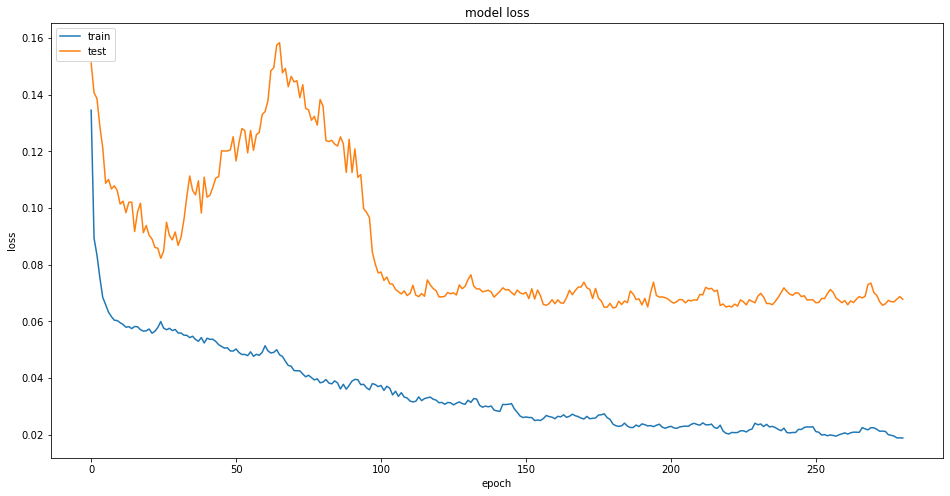

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16,8)) 
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('PV_Tl1h_TrainingandValidation Loss.png')
plt.show()

#print(get_flops(model))

In [18]:
trainPredict = model.predict(trX, batch_size=batch_size)
validPredict = model.predict(vaX, batch_size=batch_size)
testPredict = model.predict(teX, batch_size=batch_size)

In [19]:
tePredict = testPredict.reshape([-1])
testY = teY.reshape([-1])

np.savetxt('PV_Tl1h_testPredict.txt', tePredict)
 
print('Error Test Score > RMSE == ', np.sqrt(np.mean(np.square(testY-tePredict))), ' MAE == ', mean_absolute_error(testY, tePredict))

Error Test Score > RMSE ==  0.06475609800136058  MAE ==  0.03339033424125509


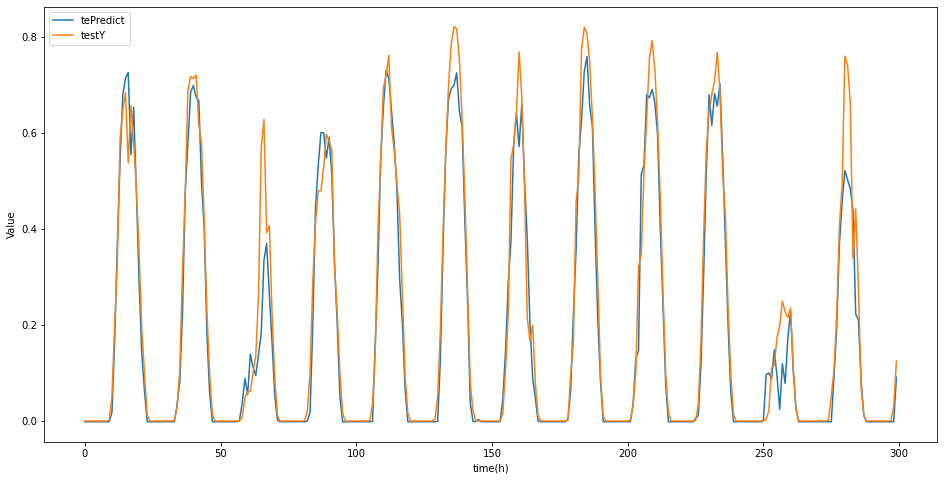

In [20]:
plt.figure(figsize=(16,8)) 
plt.plot(tePredict[0:300])
plt.plot(testY[0:300])
plt.ylabel('Value')
plt.xlabel('time(h)')
plt.legend(['tePredict', 'testY'], loc='upper left')
plt.show()

In [21]:
e_tr = trainPredict - trY
e_va = validPredict - vaY
errors = np.vstack([e_tr,e_va])
prediction = np.vstack([trainPredict,validPredict])
print(errors.shape)
print(prediction.shape)

(21470, 1)
(21470, 1)


In [22]:
e_tr = trainPredict - trY
e_va = validPredict - vaY
errors = np.vstack([e_tr,e_va])
prediction = np.vstack([trainPredict,validPredict])
print(errors.shape)
print(prediction.shape)

(21470, 1)
(21470, 1)


In [23]:
dataset = np.hstack([pv_dat, weather_dat])
index = ['Measured PV', 'Temperature C', 'Rainfall', 'Wind speed', 'Wind direction', 'Humidity', 'Air pressure', 'Dew point C', 'Sunshine', 'Solar radiation', 'Snowfall', 'Cloud cover', 'Surface temp C']

df = pd.DataFrame(dataset, columns=index)
df.head()
df = df.fillna(0)
min_max_scaler = preprocessing.MinMaxScaler()
norm_df = pd.DataFrame(min_max_scaler.fit_transform(df), 
                             columns=df.columns, 
                             index=df.index)
norm_df2 = norm_df.iloc[30:21470, [0, 4, 6, 8, 9, 11, 12]]
#norm_df2 = norm_df.iloc[30:21470, :]
norm_df2 = norm_df2.reset_index()
norm_df2 = norm_df2.iloc[:,1:]
norm_df2.head()

,Measured PV,Wind direction,Air pressure,Sunshine,Solar radiation,Cloud cover,Surface temp C
0,0.000000,0.000000,0.192037,0.0,0.000000,0.8,0.143266
1,0.000000,0.388889,0.187354,0.0,0.000000,0.8,0.144699
2,0.027907,0.388889,0.189696,0.0,0.000000,1.0,0.140401
3,0.157364,0.305556,0.192037,0.0,0.035040,0.9,0.156160
4,0.501550,0.000000,0.189696,0.9,0.167116,0.3,0.222063


In [24]:
Prindex = ['Prediction1']
Erindex = ['Error1']

pr_df = pd.DataFrame(prediction, columns=Prindex)
pr_df.head()

,Prediction1
0,-0.001574
1,-0.001574
2,0.022539
3,0.144010
4,0.447224


In [25]:
er_df = pd.DataFrame(errors, columns=Erindex)
er_df.head()

,Error1
0,-0.001574
1,-0.001574
2,-0.005368
3,-0.013355
4,-0.054327


In [26]:
norm_df2 = pd.concat([norm_df2, pr_df, er_df],axis=1)
norm_df2.head()

,Measured PV,Wind direction,Air pressure,Sunshine,Solar radiation,Cloud cover,Surface temp C,Prediction1,Error1
0,0.000000,0.000000,0.192037,0.0,0.000000,0.8,0.143266,-0.001574,-0.001574
1,0.000000,0.388889,0.187354,0.0,0.000000,0.8,0.144699,-0.001574,-0.001574
2,0.027907,0.388889,0.189696,0.0,0.000000,1.0,0.140401,0.022539,-0.005368
3,0.157364,0.305556,0.192037,0.0,0.035040,0.9,0.156160,0.144010,-0.013355
4,0.501550,0.000000,0.189696,0.9,0.167116,0.3,0.222063,0.447224,-0.054327


In [27]:
norm_df2 = np.array(norm_df2)
print(norm_df2.shape)
timesteps = 30
output_timesteps = 1
Xe, Ye = create_dataset(norm_df2[:-31,:], timesteps, output_timesteps)
print(Xe.shape)
print(Ye.shape)

(21470, 9)
(21407, 30, 9)
(21407, 1, 9)


In [28]:
trXe = Xe[:19000, :, :]
vaXe = Xe[19000:, :, :]
trYe = Ye[:19000, :, -1:]
vaYe = Ye[19000:, :, -1:]
trYe = trYe.reshape(-1,1)
vaYe = vaYe.reshape(-1,1)
print(trXe.shape)
print(trYe.shape)
print(vaXe.shape)

(19000, 30, 9)
(19000, 1)
(2407, 30, 9)


In [48]:
with tf.device('/gpu:0'):
    alpha=1.05
    gamma=1.2
    beta = 1.15011
    num_features = 9
    hfilters = 128
    hkernel_size1 = 2
    hkernel_size2 = 4
    visible1e = Input(shape=(timesteps, num_features))
    per1 = Permute((2,1))(visible1e)
    den1a = Dense(timesteps, activation='tanh')(per1)
    den1b = Dense(timesteps, activation='sigmoid')(per1)
    den1 = Multiply()([den1a, den1b])
    per2 = Permute((2,1), name='attention_vece')(den1)
    mul1 = Multiply()([visible1e, per2])
    d1 = Conv1D(filters=round(hfilters*alpha), kernel_size=round(hkernel_size1*beta), padding='causal', dilation_rate=1)(mul1)
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    d1 = Conv1D(filters=num_features, kernel_size=round(hkernel_size2*beta), padding='causal', dilation_rate=2)(d1)
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    res01 = Add()([d1, visible1e])   # (100, 25) (100, 25)
    d1 = Conv1D(filters=round(hfilters*alpha), kernel_size=round(hkernel_size1*beta), padding='causal', dilation_rate=2)(res01)
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    d1 = Conv1D(filters=num_features, kernel_size=round(hkernel_size2*beta), padding='causal', dilation_rate=4)(d1)    
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    res02 = Add()([d1, res01])   # (100, 25) (100, 25)
    d1 = Conv1D(filters=round(hfilters*alpha), kernel_size=round(hkernel_size1*beta), padding='causal', dilation_rate=4)(res02) 
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    d1 = Conv1D(filters=num_features, kernel_size=round(hkernel_size2*beta), padding='causal', dilation_rate=8)(d1) 
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    res03 = Add()([d1, res02])   # (100, 25) (100, 25)
    d1 = Conv1D(filters=round(hfilters*alpha), kernel_size=round(hkernel_size1*beta), padding='causal', dilation_rate=8)(res03)
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    d1 = Conv1D(filters=num_features, kernel_size=round(hkernel_size2*beta), padding='causal', dilation_rate=16)(d1)  
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    res04 =Add()([d1, res03])   # (100, 25) (100, 25)
    d1 = Conv1D(filters=round(hfilters*alpha), kernel_size=round(hkernel_size1*beta), padding='causal', dilation_rate=16)(res04)
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    d1 = Conv1D(filters=num_features, kernel_size=round(hkernel_size2*beta), padding='causal', dilation_rate=32)(d1)
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    res05 = Add()([d1, res04])   # (100, 25) (100, 25)
    d1 = Conv1D(filters=round(hfilters*alpha), kernel_size=round(hkernel_size1*beta), padding='causal', dilation_rate=32)(res05) 
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    d1 = Conv1D(filters=num_features, kernel_size=round(hkernel_size2*beta), padding='causal', dilation_rate=16)(d1)   
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    res06 = Add()([d1, res05])   # (100, 25) (100, 25)
    d1 = Conv1D(filters=round(hfilters*alpha), kernel_size=round(hkernel_size1*beta), padding='causal', dilation_rate=16)(res06) 
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    d1 = Conv1D(filters=num_features, kernel_size=round(hkernel_size2*beta), padding='causal', dilation_rate=8)(d1)
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    res07 = Add()([d1, res06])   # (100, 25) (100, 25)
    d1 = Conv1D(filters=round(hfilters*alpha), kernel_size=round(hkernel_size1*beta), padding='causal', dilation_rate=8)(res07)  
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    d1 = Conv1D(filters=num_features, kernel_size=round(hkernel_size2*beta), padding='causal', dilation_rate=4)(d1) 
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    res08 = Add()([d1, res07])   # (100, 25) (100, 25)
    d1 = Conv1D(filters=round(hfilters*alpha), kernel_size=round(hkernel_size1*beta), padding='causal', dilation_rate=4)(res08)   
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    d1 = Conv1D(filters=num_features, kernel_size=round(hkernel_size2*beta), padding='causal', dilation_rate=2)(d1)  
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    res09 = Add()([d1, res08])   # (100, 25) (100, 25)
    d1 = Conv1D(filters=round(hfilters*alpha), kernel_size=round(hkernel_size1*beta), padding='causal', dilation_rate=2)(res09) 
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    d1 = Conv1D(filters=num_features, kernel_size=round(hkernel_size2*beta), padding='causal', dilation_rate=1)(d1)    
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    
    res10 = Add()([d1, res09])   # 
    
    print('res10 :', res10.shape)  # (None, 24, 11) 
    
    oute = Conv1D(512, 1, padding='same', activation='relu')(res10)   # 256, 11X10=110  
    oute = Dropout(0.2)(oute)   
    
    oute = Conv1D(256, 1, padding='same', activation='relu')(oute) # 512,  110X5=550
    oute = Dropout(0.2)(oute)  
    
    oute = GlobalAveragePooling1D()(oute) # pool_size=2, strides=1
    
    oute = Dense(1)(oute) 
    modele = Model(inputs=[visible1e], outputs=[oute])
    
    print(modele.summary())
    
    modele.compile(loss=root_mean_squared_error, optimizer='adam', metrics=[root_mean_squared_error, 'mse', 'mae', 'mape'])
    early_stopping =EarlyStopping(monitor='val_loss', patience=100)
    batch_size = 100
    epochs = 1000

    history = LossHistory()
    history.init()
    
    #hist = model.fit(trX, trY, epochs=epochs, batch_size=batch_size, shuffle=False, validation_data=(vaX, vaY), callbacks=[history, early_stopping])  # , checkpoint

res10 : (?, 30, 9)
Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 30, 9)]      0                                            
__________________________________________________________________________________________________
permute_4 (Permute)             (None, 9, 30)        0           input_5[0][0]                    
__________________________________________________________________________________________________
dense_12 (Dense)                (None, 9, 30)        930         permute_4[0][0]                  
__________________________________________________________________________________________________
dense_13 (Dense)                (None, 9, 30)        930         permute_4[0][0]                  
_________________________________________________________________________

In [49]:
    %%time
    histe = modele.fit(trXe, trYe, epochs=epochs, batch_size=batch_size, shuffle=False, validation_data=(vaXe, vaYe), callbacks=[history, early_stopping])  # , checkpoint

Train on 19000 samples, validate on 2407 samples
Epoch 1/1000
19000/19000 [==============================] - ETA: 0s - loss: 0.0260 - root_mean_squared_error: 0.0260 - mean_squared_error: 0.0010 - mean_absolute_error: 0.0192 - mean_absolute_percentage_error: 735.5219    ETA: 14s - loss: 0.0551 - root_mean_squared_error: 0.0551 - mean_squ

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


19000/19000 [==============================] - 7s 350us/sample - loss: 0.0260 - root_mean_squared_error: 0.0260 - mean_squared_error: 0.0010 - mean_absolute_error: 0.0192 - mean_absolute_percentage_error: 735.5219 - val_loss: 0.0678 - val_root_mean_squared_error: 0.0681 - val_mean_squared_error: 0.0047 - val_mean_absolute_error: 0.0368 - val_mean_absolute_percentage_error: 317.9614
Epoch 2/1000
19000/19000 [==============================] - 5s 273us/sample - loss: 0.0210 - root_mean_squared_error: 0.0210 - mean_squared_error: 5.1701e-04 - mean_absolute_error: 0.0140 - mean_absolute_percentage_error: 421.4982 - val_loss: 0.0690 - val_root_mean_squared_error: 0.0679 - val_mean_squared_error: 0.0049 - val_mean_absolute_error: 0.0364 - val_mean_absolute_percentage_error: 157.3328
Epoch 3/1000
19000/19000 [==============================] - 5s 276us/sample - loss: 0.0208 - root_mean_squared_error: 0.0208 - mean_squared_error: 5.0869e-04 - mean_absolute_error: 0.0134 - mean_absolute_percentag

In [50]:
dataset = np.hstack([pv_dat, weather_dat])
index = ['Measured PV', 'Temperature C', 'Rainfall', 'Wind speed', 'Wind direction', 'Humidity', 'Air pressure', 'Dew point C', 'Sunshine', 'Solar radiation', 'Snowfall', 'Cloud cover', 'Surface temp C']

df = pd.DataFrame(dataset, columns=index)
df.head()
df = df.fillna(0)
min_max_scaler = preprocessing.MinMaxScaler()
norm_df = pd.DataFrame(min_max_scaler.fit_transform(df), 
                             columns=df.columns, 
                             index=df.index)
norm_df2 = norm_df.iloc[21500:-2, [0, 4, 6, 8, 9, 11, 12]]
#norm_df2 = norm_df.iloc[21500:-2,:]
norm_df2 = norm_df2.reset_index()
norm_df2 = norm_df2.iloc[:,1:]
norm_df2.head()

,Measured PV,Wind direction,Air pressure,Sunshine,Solar radiation,Cloud cover,Surface temp C
0,0.0,1.000000,0.426230,0.2,0.018868,0.0,0.359599
1,0.0,1.000000,0.426230,0.0,0.000000,0.0,0.348138
2,0.0,0.944444,0.409836,0.0,0.000000,0.0,0.342407
3,0.0,1.000000,0.395785,0.0,0.000000,0.0,0.335244
4,0.0,1.000000,0.381733,0.0,0.000000,0.0,0.330946


In [51]:
pr_df = pd.DataFrame(tePredict.reshape(-1,1), columns=Prindex)
pr_df.head()

,Prediction1
0,-0.001583
1,-0.001602
2,-0.001608
3,-0.001578
4,-0.001664


In [52]:
teY = testY.reshape(-1,1)
e_te = testPredict-teY
er_df = pd.DataFrame(e_te, columns=Erindex)
er_df.head()

,Error1
0,-0.001583
1,-0.001602
2,-0.001608
3,-0.001578
4,-0.001664


In [53]:
norm_df2 = pd.concat([norm_df2, pr_df, er_df], axis=1)
norm_df2.head()

,Measured PV,Wind direction,Air pressure,Sunshine,Solar radiation,Cloud cover,Surface temp C,Prediction1,Error1
0,0.0,1.000000,0.426230,0.2,0.018868,0.0,0.359599,-0.001583,-0.001583
1,0.0,1.000000,0.426230,0.0,0.000000,0.0,0.348138,-0.001602,-0.001602
2,0.0,0.944444,0.409836,0.0,0.000000,0.0,0.342407,-0.001608,-0.001608
3,0.0,1.000000,0.395785,0.0,0.000000,0.0,0.335244,-0.001578,-0.001578
4,0.0,1.000000,0.381733,0.0,0.000000,0.0,0.330946,-0.001664,-0.001664


In [54]:
norm_df2 = np.array(norm_df2)
print(norm_df2.shape)
timesteps = 30
output_timesteps = 1
eteX, eteY = create_dataset(norm_df2, timesteps, output_timesteps)
eteY = eteY[:,:,-1:].reshape(-1,1)
print(eteX.shape)
print(eteY.shape)

(9146, 9)
(9114, 30, 9)
(9114, 1)


In [55]:
etePredict = modele.predict(eteX, batch_size=batch_size)
print(etePredict.shape)
print(etePredict)

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


(9114, 1)
[[ 0.00159715]
 [ 0.00159715]
 [ 0.00159715]
 ...
 [-0.02240657]
 [-0.0068516 ]
 [ 0.002334  ]]


In [56]:
testPredict = tePredict.reshape(-1,1)
addtestPredict = -etePredict + testPredict[30:-2,:]
print(addtestPredict.shape)

(9114, 1)


In [57]:
print('Error Test Score > RMSE == ', np.sqrt(np.mean(np.square(teY[30:-2,:]-testPredict[30:-2,:]))), ' MAE == ', mean_absolute_error(teY[30:-2,:], testPredict[30:-2,:]))
print('Error Test Score > RMSE == ', np.sqrt(np.mean(np.square(teY[30:-2,:]-addtestPredict))), ' MAE == ', mean_absolute_error(teY[30:-2,:], addtestPredict))

Error Test Score > RMSE ==  0.06481331432999127  MAE ==  0.03342272756036221
Error Test Score > RMSE ==  0.06145128903463809  MAE ==  0.0318632762517116


In [46]:
np.savetxt('FSEFF_FSEFFEL_FinaltestPredict.txt', addtestPredict)

In [47]:
np.savetxt('TestY.txt', teY)

In [ ]:
layer_outputs = [layer.output for layer in modele.layers if layer.name=='attention_vece']
activation_model = tf.keras.models.Model(inputs=modele.input, outputs=layer_outputs)
attention_vectors = []
output_data = activation_model.predict(eteX, batch_size=batch_size)
output_data = np.array(output_data)
print(output_data.shape)
at_vec = np.mean(output_data, axis=0)
print(at_vec, at_vec.shape)
np.savetxt('Attention_FSEFF_FSEFFEL.txt', at_vec)
at_vec = abs(at_vec)

In [ ]:
import shap
shap.initjs()
background = trXe[np.random.choice(trXe.shape[0], 300, replace=False)]
print(background.shape)
explainer = shap.DeepExplainer(modele, background)
test_sample = trXe[-100:]
shap_values = explainer.shap_values(background)

In [ ]:
index2 = np.concatenate([index, Prindex, Erindex])

In [ ]:
shap_np = np.array(shap_values[0])
shap_np = shap_np.reshape(-1,num_features)
print("=========================================================================")
print(shap_np)
np.savetxt('SHAP_VALUES_FSEFF_FSEFFEL.txt', shap_np)